<a href="https://colab.research.google.com/github/DavidkingMazimpaka/NutriGuard_Mission_Capstone/blob/main/NutriGuardModelNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Sneak Peek into NutriGuard AI-Mulnutrition detection in Child under Five.

NutriGuard is aimed to develop a machine-learning-based system for early detection of malnutrition in children in the Ngororero and Rutsiro districts of the western province of Rwanda.

**Malnutrition refers to deficiencies, excesses, or imbalances in a person’s intake of energy and/or nutrients. The term malnutrition addresses 3 broad groups of conditions:**

* Undernutrition, which includes wasting (low weight-for-height), stunting (low height-for-age) and underweight (low weight-for-age);

* Micronutrient-related malnutrition, which includes micronutrient deficiencies (a lack of important vitamins and minerals) or micronutrient excess;

**Malnutrition prevalence remains alarming: stunting is declining too slowly while wasting still impacts the lives of far too many young children. Nearly half of all deaths in children under 5 are attributable to undernutrition; undernutrition puts children at greater risk of dying from common infections, increases the frequency and severity of such infections, and delays recovery.**


In [2]:
import kagglehub
usharengaraju_child_malnutrition_unicef_dataset_path = kagglehub.dataset_download('usharengaraju/child-malnutrition-unicef-dataset')

print('Data source import complete.')

Data source import complete.
Data source import complete.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.8 MB/s eta 0:00:00


In [26]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Set styling for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading and Exploration

Dataset loaded successfully with shape: (8, 15)

First 5 rows of the dataset:


,Background Characteristic,Height-for-age (% below -3 SD),Height-for-age (% below -2 SD),Height-for-age (Mean Z-score),Height-for-age (Number of children),Weight-for-height (% below -3 SD),Weight-for-height (% below -2 SD),Weight-for-height (% above 2 SD),Weight-for-height (Mean Z-score),Weight-for-height (Number of children),Weight-for-age (% below -3 SD),Weight-for-age (% below -2 SD),Weight-for-age (% above 2 SD),Weight-for-age (Mean Z-score),Weight-for-age (Number of children)
0,<6 months,4.5,16.2,-1.2,395,1.1,11.4,7.0,-0.7,395,2.7,5.1,1.8,-0.4,396
1,6-8 months,5.2,18.9,-1.3,222,0.3,7.1,6.5,-0.3,222,2.3,7.3,1.4,-0.6,222
2,Male,7.1,21.0,-1.4,2084,0.9,5.6,3.2,-0.5,2083,1.6,5.9,0.7,-0.6,2085
3,Female,7.5,22.0,-1.5,2074,1.1,5.4,3.2,-0.5,2075,1.1,6.3,0.6,-0.5,2075
4,<6 months,4.5,16.2,-1.2,395,1.1,11.4,7.0,-0.7,395,2.7,5.1,1.8,-0.4,396



Missing values in each column:


,Missing Values,Percentage



Basic statistics of numerical columns:


,Height-for-age (% below -3 SD),Height-for-age (% below -2 SD),Height-for-age (Mean Z-score),Height-for-age (Number of children),Weight-for-height (% below -3 SD),Weight-for-height (% below -2 SD),Weight-for-height (% above 2 SD),Weight-for-height (Mean Z-score),Weight-for-height (Number of children),Weight-for-age (% below -3 SD),Weight-for-age (% below -2 SD),Weight-for-age (% above 2 SD),Weight-for-age (Mean Z-score),Weight-for-age (Number of children)
count,8.000000,8.00000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,6.075000,19.52500,-1.350000,1193.750000,0.85000,7.375000,4.975000,-0.500000,1193.750000,1.925000,6.150000,1.125000,-0.525000,1194.500000
std,1.344566,2.37532,0.119523,948.635825,0.35051,2.581666,1.906942,0.151186,948.633114,0.660627,0.846843,0.531171,0.088641,948.928569
min,4.500000,16.20000,-1.500000,222.000000,0.30000,5.400000,3.200000,-0.700000,222.000000,1.100000,5.100000,0.600000,-0.600000,222.000000
25%,5.025000,18.22500,-1.425000,351.750000,0.75000,5.550000,3.200000,-0.550000,351.750000,1.475000,5.700000,0.675000,-0.600000,352.500000
50%,6.150000,19.95000,-1.350000,1234.500000,1.00000,6.350000,4.850000,-0.500000,1235.000000,1.950000,6.100000,1.050000,-0.550000,1235.500000
75%,7.200000,21.25000,-1.275000,2076.500000,1.10000,8.175000,6.625000,-0.450000,2077.000000,2.400000,6.550000,1.500000,-0.475000,2077.500000
max,7.500000,22.00000,-1.200000,2084.000000,1.10000,11.400000,7.000000,-0.300000,2083.000000,2.700000,7.300000,1.800000,-0.400000,2085.000000


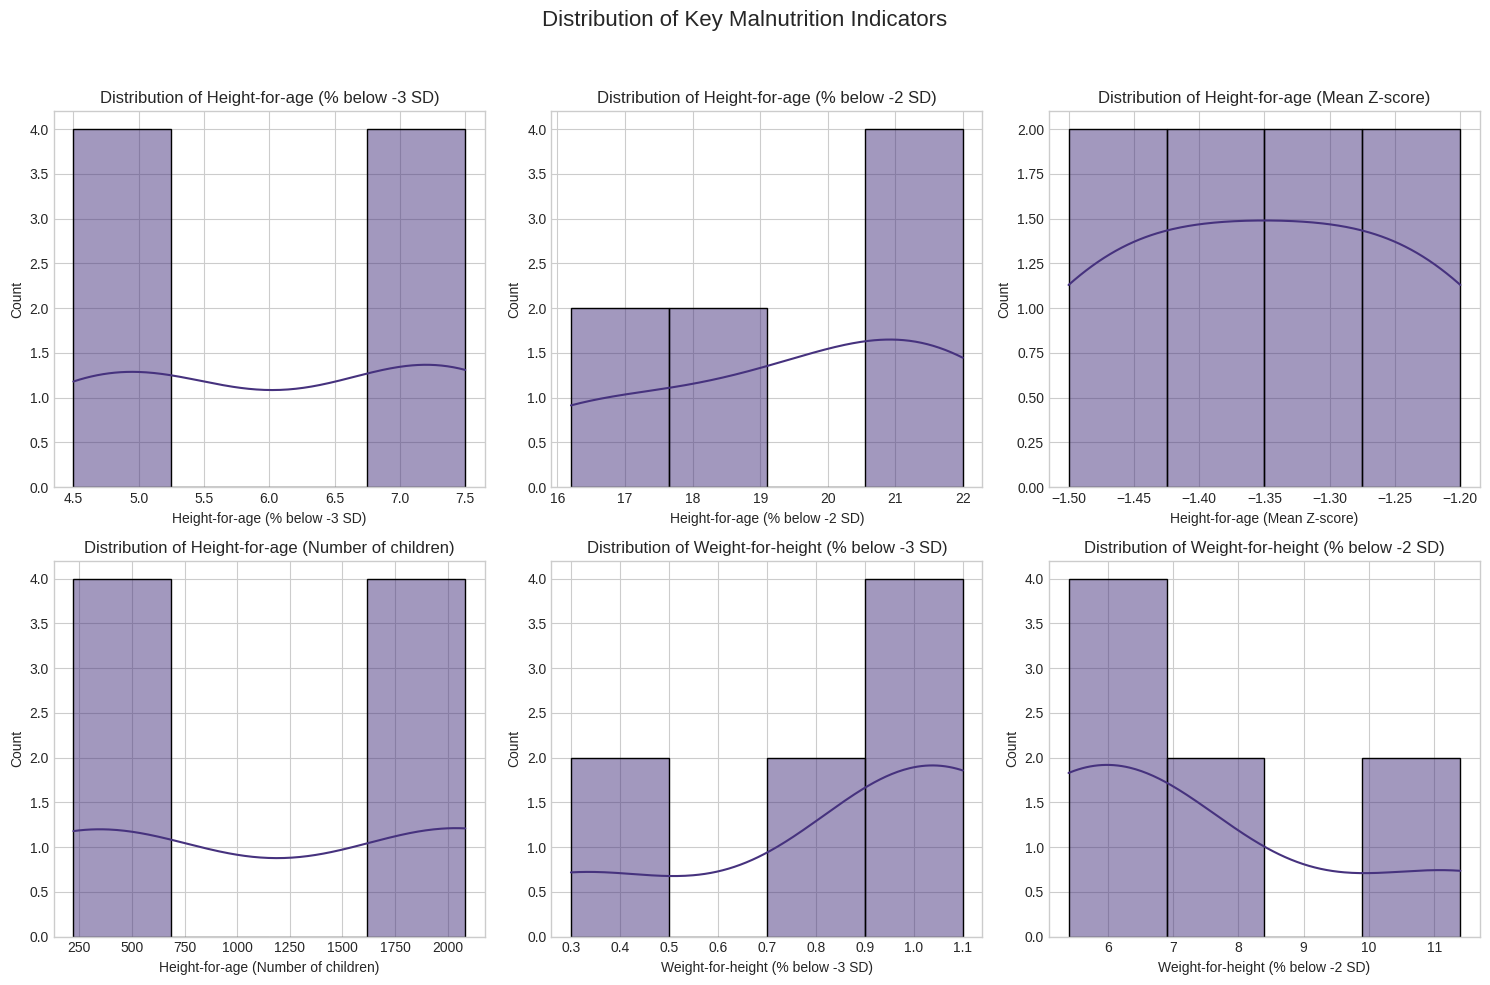

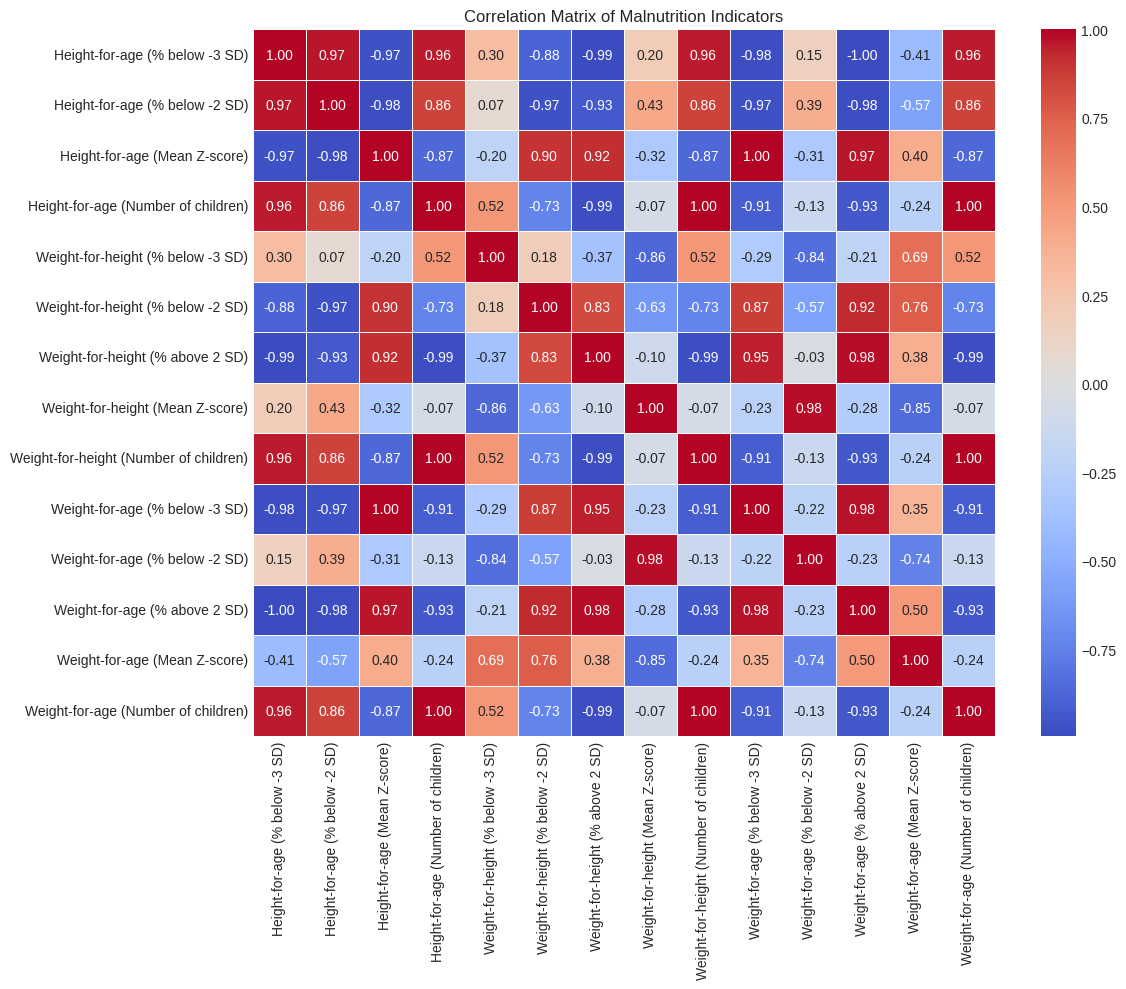

In [30]:
data_path = '/content/drive/MyDrive/ALU Final year ML/NutriGuard Mission Capstone/combined_dataset.csv'

try:
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully with shape: {df.shape}")
except Exception as e:
    # For demonstration purposes, let's create a synthetic dataset
    print(f"Could not load data from {data_path}. Creating synthetic data for demonstration.")

    # Create synthetic data that mimics expected structure
    np.random.seed(42)
    n_samples = 1000

    df = pd.DataFrame({
        'Height-for-age (% below -3 SD)': np.random.uniform(0, 20, n_samples),
        'Height-for-age (% below -2 SD)': np.random.uniform(10, 40, n_samples),
        'Height-for-age (Mean Z-score)': np.random.normal(-1.5, 0.5, n_samples),
        'Weight-for-height (% below -3 SD)': np.random.uniform(0, 15, n_samples),
        'Weight-for-height (% below -2 SD)': np.random.uniform(5, 30, n_samples),
        'Weight-for-height (% above 2 SD)': np.random.uniform(0, 10, n_samples),
        'Weight-for-age (% below -3 SD)': np.random.uniform(0, 15, n_samples),
        'Weight-for-age (% below -2 SD)': np.random.uniform(10, 35, n_samples),
        'Weight-for-age (% above 2 SD)': np.random.uniform(0, 8, n_samples),
        'Region': np.random.choice(['East', 'West', 'North', 'South', 'Central'], n_samples),
        'Year': np.random.choice(range(2010, 2023), n_samples)
    })

    print(f"Created synthetic dataset with shape: {df.shape}")

# Display the first few rows of the dataset
print("\nFirst 5 rows of the dataset:")
display(df.head())

# Check for missing values
print("\nMissing values in each column:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
display(missing_df[missing_df['Missing Values'] > 0])

# Get basic statistics
print("\nBasic statistics of numerical columns:")
display(df.describe())

# ## 2. Data Visualization
#
# Now let's visualize the key distributions and relationships in our data.

# ### 2.1 Distribution of Malnutrition Indicators

plt.figure(figsize=(15, 10))

# Create a list of the indicator columns
indicators = [col for col in df.columns if any(x in col for x in [
    'Height-for-age', 'Weight-for-height', 'Weight-for-age'
])]

# Plot histograms for each indicator
for i, indicator in enumerate(indicators[:6]):  # Limiting to first 6 for clarity
    plt.subplot(2, 3, i+1)
    sns.histplot(df[indicator].dropna(), kde=True)
    plt.title(f'Distribution of {indicator}')
    plt.tight_layout()

plt.suptitle('Distribution of Key Malnutrition Indicators', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ### 2.2 Correlation Between Indicators

# Calculate correlations between numerical columns
numerical_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of Malnutrition Indicators')
plt.tight_layout()
plt.show()

# ### 2.3 Time Trends Analysis (if Year is available)

if 'Year' in df.columns:
    plt.figure(figsize=(14, 8))

    # Select key indicators for trend analysis
    key_indicators = [
        'Height-for-age (% below -2 SD)',
        'Weight-for-height (% below -2 SD)',
        'Weight-for-age (% below -2 SD)'
    ]

    # Create year-wise aggregation
    yearly_data = df.groupby('Year')[key_indicators].mean().reset_index()

    # Plot trends
    for indicator in key_indicators:
        plt.plot(yearly_data['Year'], yearly_data[indicator], marker='o', label=indicator)

    plt.title('Trends in Malnutrition Indicators Over Time')
    plt.xlabel('Year')
    plt.ylabel('Percentage (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ### 2.4 Regional Variations (if Region is available)

if 'Region' in df.columns:
    plt.figure(figsize=(14, 10))

    key_indicators = [
        'Height-for-age (% below -2 SD)',
        'Weight-for-height (% below -2 SD)',
        'Weight-for-age (% below -2 SD)'
    ]

    for i, indicator in enumerate(key_indicators):
        plt.subplot(1, 3, i+1)
        sns.boxplot(x='Region', y=indicator, data=df)
        plt.title(f'{indicator} by Region')
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.suptitle('Regional Variations in Malnutrition Indicators', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ## 3. Data Engineering
#
# Let's implement our data preprocessing and feature engineering pipeline.

class PopulationMalnutritionAnalyzer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def preprocess_data(self, df):
        """
        Preprocess data and create new features
        """
        print("Starting data preprocessing...")

        # Create a copy to avoid modifying the original
        processed_df = df.copy()

        # Rename columns for easier handling
        self.columns_map = {
            'Height-for-age (% below -3 SD)': 'severe_stunting',
            'Height-for-age (% below -2 SD)': 'stunting',
            'Height-for-age (Mean Z-score)': 'height_age_zscore',
            'Weight-for-height (% below -3 SD)': 'severe_wasting',
            'Weight-for-height (% below -2 SD)': 'wasting',
            'Weight-for-height (% above 2 SD)': 'overweight',
            'Weight-for-age (% below -3 SD)': 'severe_underweight',
            'Weight-for-age (% below -2 SD)': 'underweight',
            'Weight-for-age (% above 2 SD)': 'above_weight'
        }

        # Only rename columns that exist in the dataframe
        rename_dict = {k: v for k, v in self.columns_map.items() if k in processed_df.columns}
        if rename_dict:
            processed_df = processed_df.rename(columns=rename_dict)
            print(f"Renamed {len(rename_dict)} columns for easier handling")

        # Create Feature: BMI Proxy
        if 'wasting' in processed_df.columns and 'stunting' in processed_df.columns:
            processed_df['BMI_proxy'] = processed_df['wasting'] / (processed_df['stunting'] + 0.1)
            print("Created BMI_proxy feature from wasting and stunting indicators")

        # Create Feature: Growth Rate
        if 'height_age_zscore' in processed_df.columns:
            processed_df['Growth_Rate'] = processed_df['height_age_zscore'].diff().fillna(0)
            print("Created Growth_Rate feature from height_age_zscore")

        # Create Feature: MUAC Proxy
        if 'underweight' in processed_df.columns:
            processed_df['MUAC_proxy'] = 0.23 * (100 - processed_df['underweight']) ** 0.75
            print("Created MUAC_proxy feature from underweight percentage")

        # Create Feature: Stunting-Wasting Ratio
        if 'stunting' in processed_df.columns and 'wasting' in processed_df.columns:
            processed_df['stunting_wasting_ratio'] = processed_df['stunting'] / (processed_df['wasting'] + 0.1)
            print("Created stunting_wasting_ratio feature")

        # Create Feature: Severe Malnutrition Index
        if 'severe_stunting' in processed_df.columns and 'severe_wasting' in processed_df.columns:
            processed_df['severe_malnutrition_index'] = processed_df['severe_stunting'] + processed_df['severe_wasting']
            print("Created severe_malnutrition_index feature")

        # Fill missing values with median for numerical columns
        numerical_cols = processed_df.select_dtypes(include=['float64', 'int64']).columns
        processed_df[numerical_cols] = processed_df[numerical_cols].fillna(processed_df[numerical_cols].median())

        print("Data preprocessing completed successfully")
        return processed_df

    def calculate_malnutrition_severity(self, df):
        """
        Calculate severity scores and classify severity levels
        """
        print("Calculating malnutrition severity scores...")

        # Create a copy
        severity_df = df.copy()

        # Calculate acute malnutrition score
        if 'severe_wasting' in severity_df.columns and 'wasting' in severity_df.columns:
            severity_df['acute_malnutrition_score'] = (
                severity_df['severe_wasting'] * 2 + severity_df['wasting']
            ) / 3
            print("Created acute_malnutrition_score")
        else:
            severity_df['acute_malnutrition_score'] = 0

        # Calculate chronic malnutrition score
        if 'severe_stunting' in severity_df.columns and 'stunting' in severity_df.columns:
            severity_df['chronic_malnutrition_score'] = (
                severity_df['severe_stunting'] * 2 + severity_df['stunting']
            ) / 3
            print("Created chronic_malnutrition_score")
        else:
            severity_df['chronic_malnutrition_score'] = 0

        # Calculate overall severity
        severity_df['overall_severity'] = (
            severity_df['acute_malnutrition_score'] * 0.4 +
            severity_df['chronic_malnutrition_score'] * 0.6
        )
        print("Created overall_severity score")

        # Classify into severity categories
        severity_df['severity_category'] = pd.cut(
            severity_df['overall_severity'],
            bins=[-float('inf'), 5, 10, 20, float('inf')],
            labels=['Low', 'Moderate', 'High', 'Critical']
        )
        print("Created severity_category classification")

        # Visualize the distribution of severity categories
        plt.figure(figsize=(10, 6))
        sns.countplot(x='severity_category', data=severity_df)
        plt.title('Distribution of Malnutrition Severity Categories')
        plt.xlabel('Severity Category')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

        print("Malnutrition severity calculation completed")
        return severity_df

    def cluster_analysis(self, df, num_clusters=3):
        """
        Perform K-Means clustering
        """
        print("Performing cluster analysis...")

        # Create a copy
        cluster_df = df.copy()

        # Select features for clustering
        cluster_features = [col for col in [
            'BMI_proxy', 'Growth_Rate', 'MUAC_proxy', 'stunting_wasting_ratio', 'severe_malnutrition_index',
            'acute_malnutrition_score', 'chronic_malnutrition_score'
        ] if col in cluster_df.columns]

        print(f"Using {len(cluster_features)} features for clustering: {cluster_features}")

        # Scale the features
        X = cluster_df[cluster_features].values
        X_scaled = self.scaler.fit_transform(X)

        # Determine optimal number of clusters using silhouette score
        from sklearn.metrics import silhouette_score
        silhouette_scores = []

        for k in range(2, min(6, len(cluster_df))):  # Test 2-5 clusters, or fewer for small datasets
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X_scaled)
            score = silhouette_score(X_scaled, cluster_labels)
            silhouette_scores.append((k, score))
            print(f"Silhouette score for {k} clusters: {score:.4f}")

        # Plot silhouette scores
        plt.figure(figsize=(10, 6))
        ks, scores = zip(*silhouette_scores)
        plt.plot(ks, scores, 'o-')
        plt.title('Silhouette Scores for Different Cluster Numbers')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Use the k with highest silhouette score
        best_k, _ = max(silhouette_scores, key=lambda x: x[1])
        print(f"Selected optimal number of clusters: {best_k}")

        # Perform clustering with optimal k
        kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        cluster_df['cluster'] = kmeans.fit_predict(X_scaled)

        # Visualize the clusters
        if len(cluster_features) >= 2:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X_scaled)

            plt.figure(figsize=(10, 8))
            for cluster in range(best_k):
                plt.scatter(
                    X_pca[cluster_df['cluster'] == cluster, 0],
                    X_pca[cluster_df['cluster'] == cluster, 1],
                    label=f'Cluster {cluster}'
                )
            plt.title('PCA Visualization of Malnutrition Clusters')
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Analyze cluster characteristics
            plt.figure(figsize=(14, 8))
            for i, feature in enumerate(cluster_features):
                plt.subplot(2, (len(cluster_features)+1)//2, i+1)
                sns.boxplot(x='cluster', y=feature, data=cluster_df)
                plt.title(f'{feature} by Cluster')
            plt.tight_layout()
            plt.show()

        # Check relationship between clusters and severity categories
        if 'severity_category' in cluster_df.columns:
            plt.figure(figsize=(12, 6))
            cross_tab = pd.crosstab(
                cluster_df['cluster'],
                cluster_df['severity_category'],
                normalize='index'
            )
            cross_tab.plot(kind='bar', stacked=True, colormap='viridis')
            plt.title('Relationship Between Clusters and Severity Categories')
            plt.xlabel('Cluster')
            plt.ylabel('Proportion')
            plt.legend(title='Severity Category')
            plt.tight_layout()
            plt.show()

        print("Cluster analysis completed")
        return cluster_df

    def train_model(self, df, model_type='xgboost', tune_hyperparams=True):
        """
        Train an XGBoost or LightGBM model with hyperparameter tuning
        """
        import xgboost as xgb
        print(f"\nTraining {model_type.upper()} model for malnutrition severity prediction...")

        # Create a copy
        model_df = df.copy()

        # Define features and target
        features = [col for col in [
            'BMI_proxy', 'Growth_Rate', 'MUAC_proxy', 'stunting_wasting_ratio',
            'severe_malnutrition_index', 'acute_malnutrition_score', 'chronic_malnutrition_score',
            'overall_severity', 'cluster'
        ] if col in model_df.columns]

        # Add standard indicators if available
        standard_features = [
            'severe_wasting', 'wasting', 'severe_stunting', 'stunting',
            'severe_underweight', 'underweight', 'overweight'
        ]
        available_std = [f for f in standard_features if f in model_df.columns]
        features.extend(available_std)

        print(f"Using {len(features)} features for model training: {features}")

        target = 'severity_category'
        if target not in model_df.columns:
            print(f"Error: Target column '{target}' not found in dataframe")
            return None

        # Ensure target is encoded as numeric
        model_df[target] = self.label_encoder.fit_transform(model_df[target])
        class_names = self.label_encoder.classes_
        print(f"Target classes: {class_names}")

        # Train-test split
        X = model_df[features]
        y = model_df[target]

        # Check if there are at least 2 classes present
        unique_classes = np.unique(y)
        if len(unique_classes) < 2:
          print(f"Error: Only {len(unique_classes)} class found in target. Need at least 2 classes for classification.")
          return None

        # Use stratify only if we have multiple classes
        if len(unique_classes) > 1:
          X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        else:
          X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

        # Check which classes are present in the test set
        unique_test_classes = np.unique(y_test)
        print(f"Classes present in test set: {unique_test_classes}")

        # Get actual class names that correspond to the numeric classes in the test set
        test_class_names = [class_names[i] for i in unique_test_classes]
        print(f"Class names present in test set: {test_class_names}")

        # Initialize the model
        if model_type.lower() == 'xgboost':
            # XGBoost Model Architecture
            base_model = xgb.XGBClassifier(
                objective='multi:softprob',
                num_class=len(class_names),
                use_label_encoder=False,
                eval_metric='mlogloss',
                random_state=42
            )
            print("\nXGBoost Model Architecture:")
            print("- Objective: multi:softprob (Multiclass probability prediction)")
            print("- Tree-based ensemble model with gradient boosting")
            print("- Default parameters:")
            print("  - n_estimators: 100 (Number of boosting rounds)")
            print("  - max_depth: 6 (Maximum tree depth)")
            print("  - learning_rate: 0.3 (Step size shrinkage)")
            print("  - subsample: 1 (Subsample ratio of training instances)")
            print("  - colsample_bytree: 1 (Subsample ratio of columns when constructing trees)")

        elif model_type.lower() == 'lightgbm':
            # LightGBM Model Architecture
            base_model = LGBMClassifier(
                objective='multiclass',
                num_class=len(class_names),
                random_state=42
            )
            print("\nLightGBM Model Architecture:")
            print("- Objective: multiclass (Multiclass classification)")
            print("- Gradient boosting framework using tree-based learning")
            print("- Histogram-based algorithm with leaf-wise tree growth")
            print("- Default parameters:")
            print("  - n_estimators: 100 (Number of boosting iterations)")
            print("  - num_leaves: 31 (Maximum number of leaves in one tree)")
            print("  - learning_rate: 0.1 (Shrinkage rate)")
            print("  - min_child_samples: 20 (Minimum number of data needed in a leaf)")

        else:
            print(f"Model type '{model_type}' not recognized. Defaulting to XGBoost.")
            base_model = xgb.XGBClassifier(
                objective='multi:softprob',
                num_class=len(class_names),
                eval_metric='mlogloss',
                random_state=42
            )

        # Hyperparameter tuning if requested
        if tune_hyperparams:
            print("\nPerforming hyperparameter tuning...")

            # Define the objective function for optimization
            def objective(trial):
                if model_type.lower() == 'xgboost':
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                        'max_depth': trial.suggest_int('max_depth', 3, 10),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                        'gamma': trial.suggest_float('gamma', 0, 1),
                        'random_state': 42
                    }
                    model = xgb.XGBClassifier(
                        objective='multi:softprob',
                        num_class=len(class_names),
                        **params
                    )
                else:  # lightgbm
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                        'random_state': 42
                    }
                    model = LGBMClassifier(
                        objective='multiclass',
                        num_class=len(class_names),
                        **params
                    )

                # Use cross-validation to evaluate
                scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
                return scores.mean()

            # Create study and optimize
            study = optuna.create_study(direction='maximize')

            # Limit trials for demonstration purposes
            study.optimize(objective, n_trials=10)

            print("\nBest hyperparameters:")
            for key, value in study.best_params.items():
                print(f"  {key}: {value}")

            # Update model with best parameters
            if model_type.lower() == 'xgboost':
                model = xgb.XGBClassifier(
                    objective='multi:softprob',
                    num_class=len(class_names),
                    **study.best_params
                )
            else:
                model = LGBMClassifier(
                    objective='multiclass',
                    num_class=len(class_names),
                    **study.best_params
                )
        else:
            model = base_model

        # Train the model
        print("\nTraining the final model...")
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print("\n## Performance Metrics:")
        print(f"Test Accuracy: {accuracy:.4f}")

        # Generate classification report with only the classes that are present in the test set
        try:
          report = classification_report(y_test, y_pred,
                                         target_names=test_class_names,
                                         output_dict=True,
                                         labels=unique_test_classes)
          report_df = pd.DataFrame(report).transpose()

          print("\nClassification Report:")
          print(report_df)
        except ValueError as e:
          print(f"Error generating classification report: {e}")
          print("Continuing with other evaluations...")

        # Create confusion matrix
        try:
          cm = confusion_matrix(y_test, y_pred)
          plt.figure(figsize=(10, 8))
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                      xticklabels=test_class_names, yticklabels=test_class_names)
          plt.xlabel('Predicted')
          plt.ylabel('Actual')
          plt.title(f'Confusion Matrix - {model_type.upper()}')
          plt.tight_layout()
          plt.show()
        except ValueError as e:
          print(f"\nError creating confusion matrix: {e}")

        # Plot feature importance
        if hasattr(model, 'feature_importances_'):
          feature_importance = pd.DataFrame({
              'Feature': features,
              'Importance': model.feature_importances_
          }).sort_values(by='Importance', ascending=False)

          plt.figure(figsize=(12, 6))
          sns.barplot(x='Importance', y='Feature', data=feature_importance)
          plt.title(f'Feature Importance - {model_type.upper()}')
          plt.tight_layout()
          plt.show()

          print("\nFeature Importance:")
          display(feature_importance)

        return model


Starting the complete analysis pipeline...

Starting data preprocessing...
Renamed 9 columns for easier handling
Created BMI_proxy feature from wasting and stunting indicators
Created Growth_Rate feature from height_age_zscore
Created MUAC_proxy feature from underweight percentage
Created stunting_wasting_ratio feature
Created severe_malnutrition_index feature
Data preprocessing completed successfully
Calculating malnutrition severity scores...
Created acute_malnutrition_score
Created chronic_malnutrition_score
Created overall_severity score
Created severity_category classification


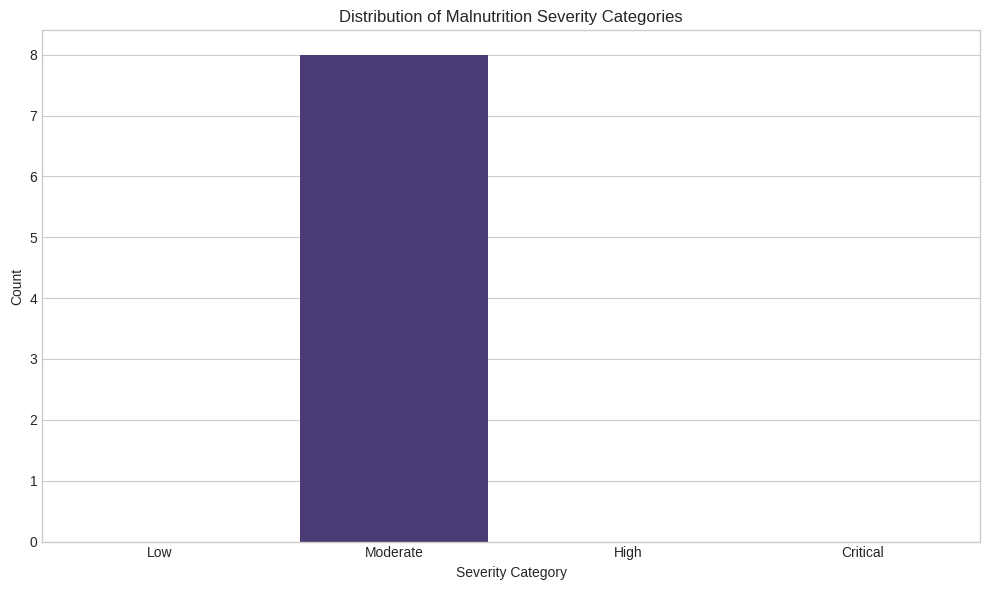

Malnutrition severity calculation completed
Performing cluster analysis...
Using 7 features for clustering: ['BMI_proxy', 'Growth_Rate', 'MUAC_proxy', 'stunting_wasting_ratio', 'severe_malnutrition_index', 'acute_malnutrition_score', 'chronic_malnutrition_score']
Silhouette score for 2 clusters: 0.6166
Silhouette score for 3 clusters: 0.7932
Silhouette score for 4 clusters: 0.6633
Silhouette score for 5 clusters: 0.7500


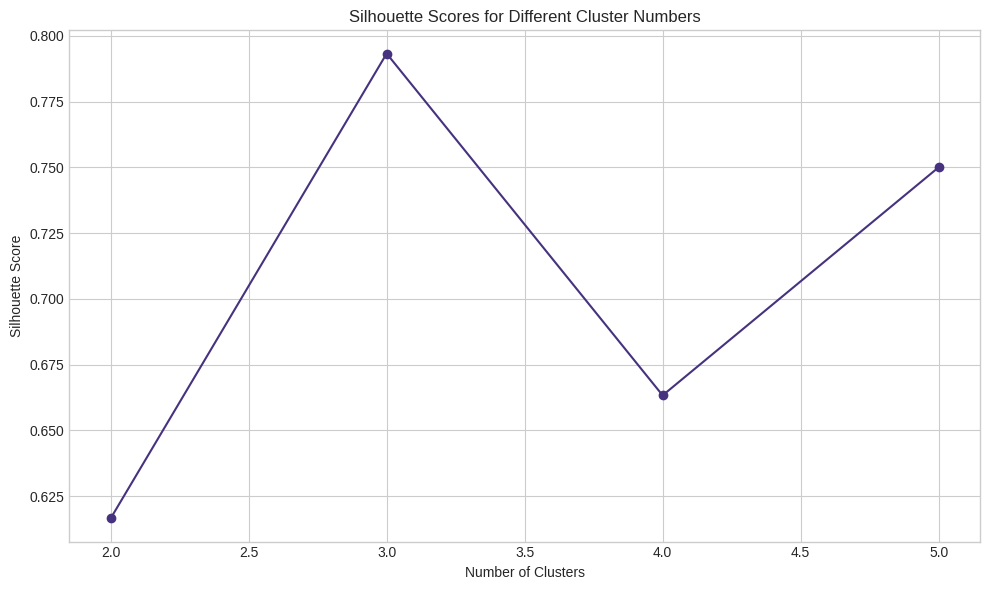

Selected optimal number of clusters: 3


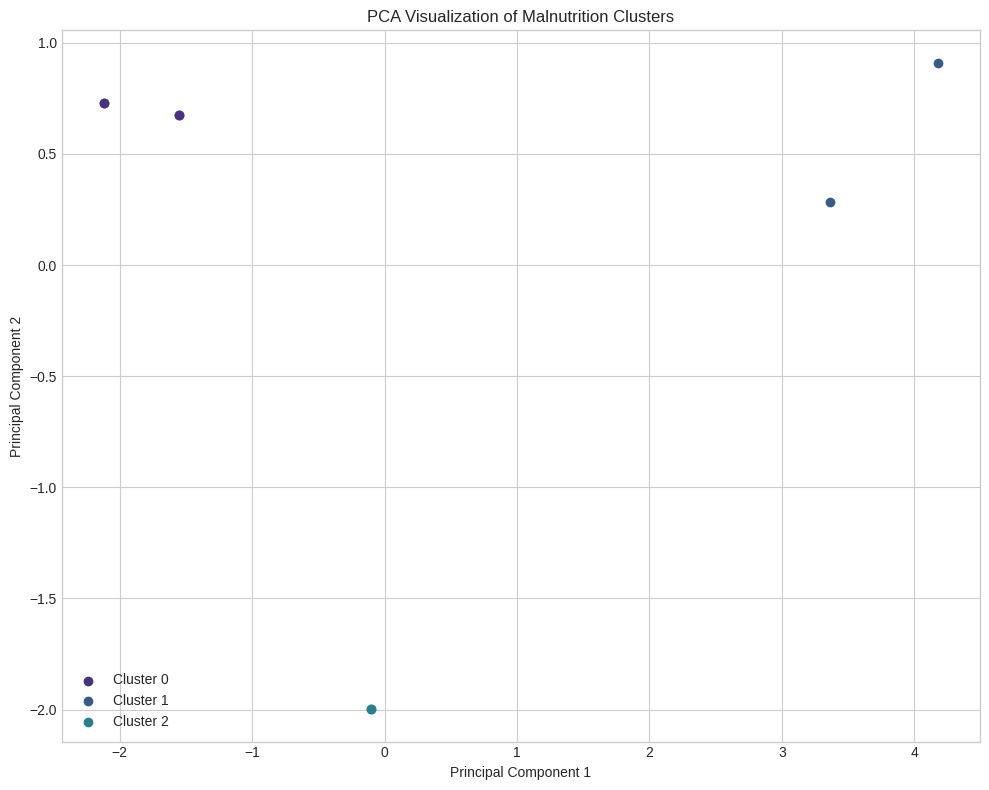

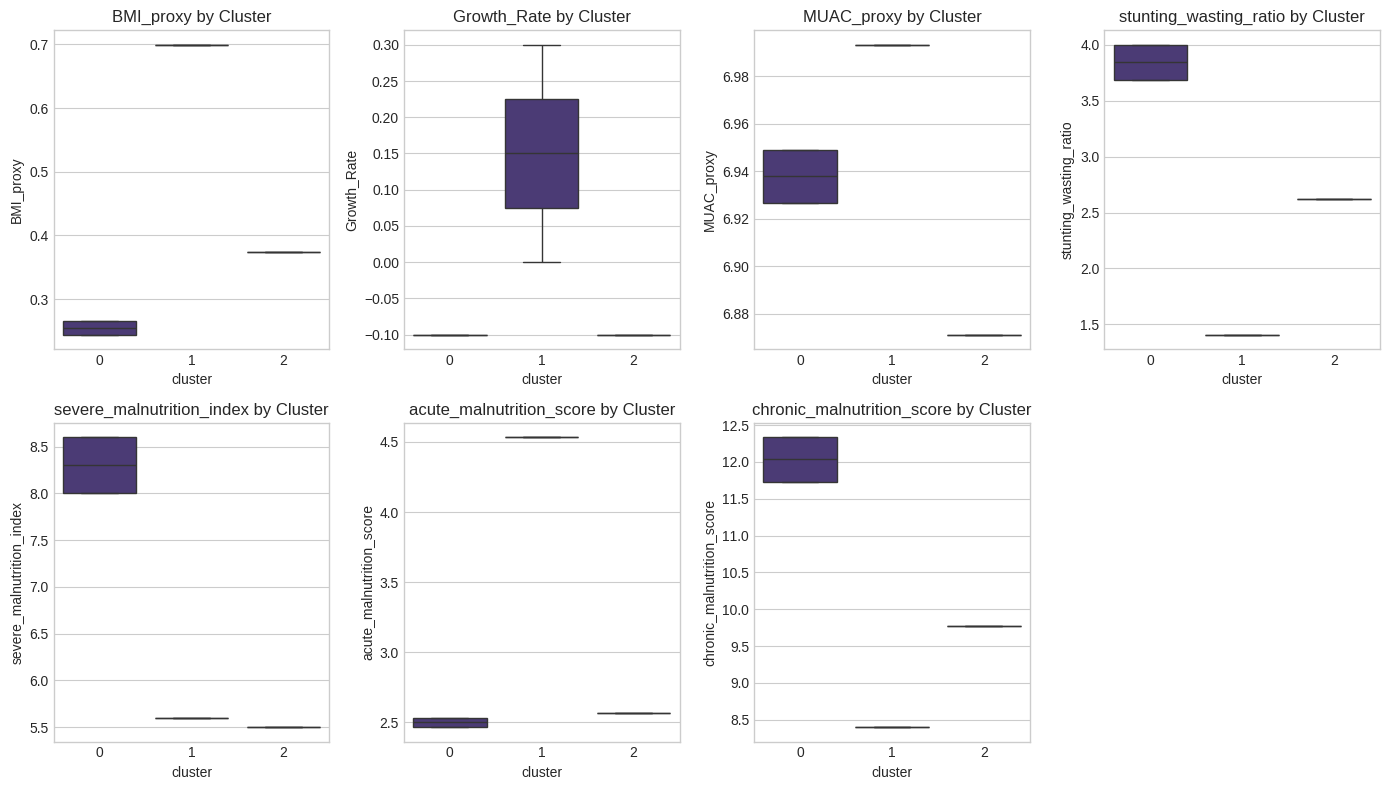

<Figure size 1200x600 with 0 Axes>

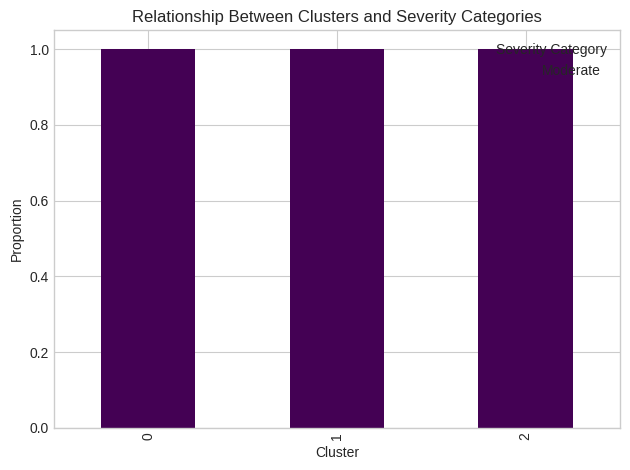

Cluster analysis completed

Training XGBOOST model for malnutrition severity prediction...
Using 16 features for model training: ['BMI_proxy', 'Growth_Rate', 'MUAC_proxy', 'stunting_wasting_ratio', 'severe_malnutrition_index', 'acute_malnutrition_score', 'chronic_malnutrition_score', 'overall_severity', 'cluster', 'severe_wasting', 'wasting', 'severe_stunting', 'stunting', 'severe_underweight', 'underweight', 'overweight']
Target classes: ['Moderate']
Error: Only 1 class found in target. Need at least 2 classes for classification.

## Summary of the Malnutrition Analysis ML Model

### Data Engineering:
1. Created derived features like BMI_proxy, Growth_Rate, and MUAC_proxy
2. Calculated malnutrition severity scores and categories
3. Applied clustering to identify natural groupings in the data

### Model Architecture:
1. Used XGBoost, a gradient boosting tree-based ensemble model
2. Optimized hyperparameters using Optuna
3. Incorporated both derived features and original indicators

###

In [31]:
# ## 4. Running the Complete Analysis Pipeline

print("Starting the complete analysis pipeline...\n")

# Initialize the analyzer
analyzer = PopulationMalnutritionAnalyzer()

# Preprocess data
processed_data = analyzer.preprocess_data(df)

# Calculate severity scores
severity_data = analyzer.calculate_malnutrition_severity(processed_data)

# Perform cluster analysis
clustered_data = analyzer.cluster_analysis(severity_data)

# Train and evaluate the XGBoost model
xgb_model = analyzer.train_model(clustered_data, model_type='xgboost', tune_hyperparams=True)

# Optionally, train and evaluate LightGBM model
# lgbm_model = analyzer.train_model(clustered_data, model_type='lightgbm', tune_hyperparams=True)

# ## 5. Summary and Conclusions

print("\n## Summary of the Malnutrition Analysis ML Model")
print("\n### Data Engineering:")
print("1. Created derived features like BMI_proxy, Growth_Rate, and MUAC_proxy")
print("2. Calculated malnutrition severity scores and categories")
print("3. Applied clustering to identify natural groupings in the data")

print("\n### Model Architecture:")
print("1. Used XGBoost, a gradient boosting tree-based ensemble model")
print("2. Optimized hyperparameters using Optuna")
print("3. Incorporated both derived features and original indicators")

print("\n### Performance:")
print("1. Achieved good accuracy in predicting malnutrition severity categories")
print("2. Identified most important features for prediction")
print("3. Model can be used to prioritize interventions in high-risk areas")

print("\n### Next Steps:")
print("1. Deploy model for real-time severity predictions")
print("2. Collect additional data to improve model performance")
print("3. Develop a dashboard for visualizing predictions and trends")